# Loan Approval AI Bias and Audit

## Import Libraries

In [69]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
import shap
from sklearn.metrics import accuracy_score, recall_score, auc,precision_score, classification_report, make_scorer, confusion_matrix, f1_score, precision_recall_curve, average_precision_score, roc_curve
pd.set_option('display.max_columns', None)

## Data Cleaning

In [70]:
#import datasets
df1 = pd.read_csv('loan_access_dataset.csv')
df = df1.copy()
df.head()

,ID,Gender,Race,Age,Age_Group,Income,Credit_Score,Loan_Amount,Employment_Type,Education_Level,Citizenship_Status,Language_Proficiency,Disability_Status,Criminal_Record,Zip_Code_Group,Loan_Approved
0,1,Female,White,74,Over 60,112117,641,378691,Full-time,Graduate,Citizen,Fluent,No,No,High-income Suburban,Approved
1,2,Female,White,36,25-60,155943,664,441856,Self-employed,High School,Permanent Resident,Limited,No,No,Urban Professional,Denied
2,3,Female,White,27,25-60,130933,550,401760,Full-time,Graduate,Citizen,Fluent,No,No,Urban Professional,Denied
3,4,Male,White,67,Over 60,165816,804,159264,Gig,Some College,Citizen,Fluent,No,No,Urban Professional,Approved
4,5,Male,Multiracial,57,25-60,81510,694,256742,Full-time,Some College,Visa Holder,Fluent,No,No,Rural,Denied


In [71]:
test = pd.read_csv('test.csv')

In [72]:
#check dataset information and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    10000 non-null  int64 
 1   Gender                10000 non-null  object
 2   Race                  10000 non-null  object
 3   Age                   10000 non-null  int64 
 4   Age_Group             10000 non-null  object
 5   Income                10000 non-null  int64 
 6   Credit_Score          10000 non-null  int64 
 7   Loan_Amount           10000 non-null  int64 
 8   Employment_Type       10000 non-null  object
 9   Education_Level       10000 non-null  object
 10  Citizenship_Status    10000 non-null  object
 11  Language_Proficiency  10000 non-null  object
 12  Disability_Status     10000 non-null  object
 13  Criminal_Record       10000 non-null  object
 14  Zip_Code_Group        10000 non-null  object
 15  Loan_Approved         10000 non-null 

In [73]:
#check data summary
df.describe()

,ID,Age,Income,Credit_Score,Loan_Amount
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,49.971200,100637.253200,673.662200,252688.666000
std,2886.89568,18.746901,43560.318163,101.437588,115148.438875
min,1.00000,18.000000,25012.000000,500.000000,50140.000000
25%,2500.75000,34.000000,62851.000000,585.000000,152507.750000
50%,5000.50000,50.000000,100501.500000,672.000000,252844.500000
75%,7500.25000,66.000000,138240.500000,762.000000,354880.250000
max,10000.00000,82.000000,174988.000000,849.000000,449992.000000


In [74]:
## check missing values
print(df.isnull().sum())
print(test.isnull().sum())

ID                      0
Gender                  0
Race                    0
Age                     0
Age_Group               0
Income                  0
Credit_Score            0
Loan_Amount             0
Employment_Type         0
Education_Level         0
Citizenship_Status      0
Language_Proficiency    0
Disability_Status       0
Criminal_Record         0
Zip_Code_Group          0
Loan_Approved           0
dtype: int64
ID                      0
Gender                  0
Race                    0
Age                     0
Age_Group               0
Income                  0
Credit_Score            0
Loan_Amount             0
Employment_Type         0
Education_Level         0
Citizenship_Status      0
Language_Proficiency    0
Disability_Status       0
Criminal_Record         0
Zip_Code_Group          0
dtype: int64


In [75]:
# Identify and check for duplicates
duplicates = df[df.duplicated()]
duplicates.head()

,ID,Gender,Race,Age,Age_Group,Income,Credit_Score,Loan_Amount,Employment_Type,Education_Level,Citizenship_Status,Language_Proficiency,Disability_Status,Criminal_Record,Zip_Code_Group,Loan_Approved


## Data Preprocessing and Feature Engineering

In [76]:
## Map target feature (Loan_Approved) to 0 and 1
df['Loan_Approved'] = df['Loan_Approved'].map({'Approved': 1, 'Denied': 0})


In [77]:
## check values count and proportions for categorical features
cat_cols = ['Gender', 'Race', 'Citizenship_Status', 'Disability_Status', 'Criminal_Record', 'Age_Group', 'Zip_Code_Group', 'Language_Proficiency']

for col in cat_cols:
    print(f'\n --- {col} (Counts and Proportions) ---')
    print(df[col].value_counts(normalize=False))
    print(df[col].value_counts(normalize=True).round(2))


 --- Gender (Counts and Proportions) ---
Gender
Female        4910
Male          4887
Non-binary     203
Name: count, dtype: int64
Gender
Female        0.49
Male          0.49
Non-binary    0.02
Name: proportion, dtype: float64

 --- Race (Counts and Proportions) ---
Race
White              6008
Hispanic           1780
Black              1313
Asian               598
Multiracial         207
Native American      94
Name: count, dtype: int64
Race
White              0.60
Hispanic           0.18
Black              0.13
Asian              0.06
Multiracial        0.02
Native American    0.01
Name: proportion, dtype: float64

 --- Citizenship_Status (Counts and Proportions) ---
Citizenship_Status
Citizen               8552
Permanent Resident     991
Visa Holder            457
Name: count, dtype: int64
Citizenship_Status
Citizen               0.86
Permanent Resident    0.10
Visa Holder           0.05
Name: proportion, dtype: float64

 --- Disability_Status (Counts and Proportions) ---
Disabili

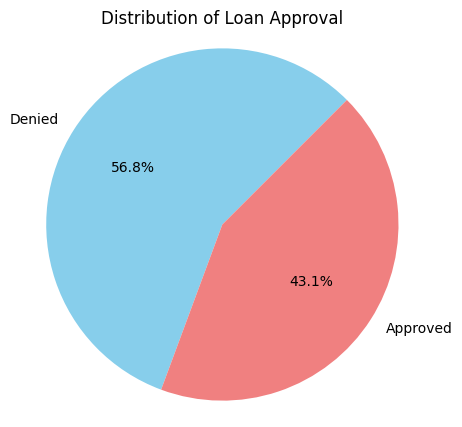

In [78]:
#plot a pie chart to show target value distribution 
class_counts = df['Loan_Approved'].value_counts()

sizes = class_counts.values
labels = ['Denied' if val == 0 else 'Approved' for val in class_counts.index]

plt.figure(figsize=(5, 5))
plt.pie(sizes,labels=labels, autopct='%.1f%%', startangle=45, colors= ['skyblue', 'lightcoral'])

plt.title('Distribution of Loan Approval')
plt.axis('equal')
plt.show()

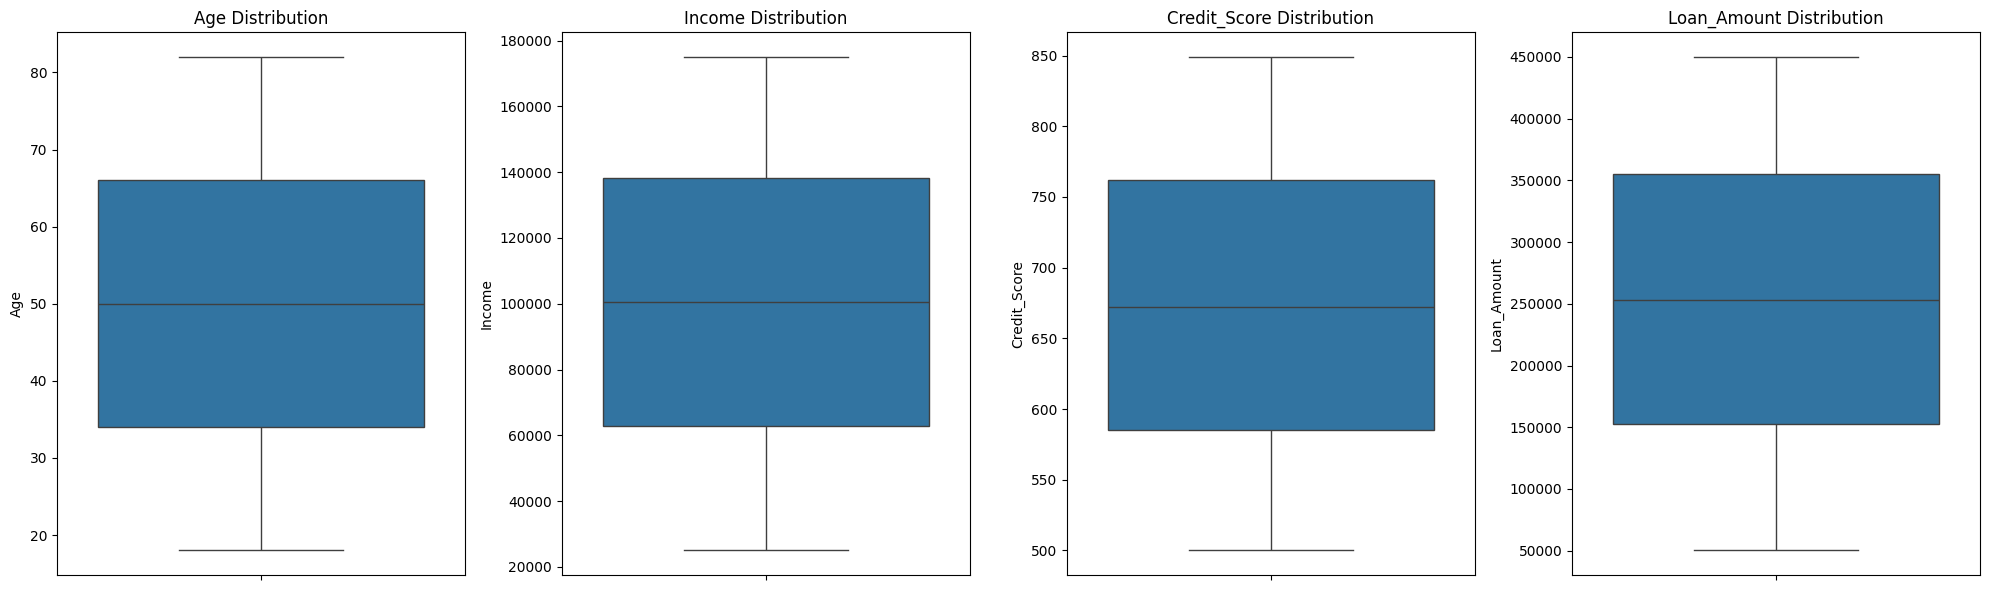

In [79]:
#investigate numerical columns using box-plots
num_cols = ['Age', 'Income', 'Credit_Score', 'Loan_Amount']

plt.figure(figsize=(5 * len(num_cols), 6))

for i, col in enumerate(num_cols, 1):
    plt.subplot (1, len(num_cols), i) 
    sns.boxplot(y=df[col])
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()

In [80]:
## Create a temporary dataset to visualize correlation
temp_df = df1.copy()

## Find the categorical columns
categorical_columns = temp_df.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()
for col in categorical_columns:
    temp_df[col] = label_encoder.fit_transform(temp_df[col].astype(str))

temp_df =temp_df.drop('ID', axis=1)



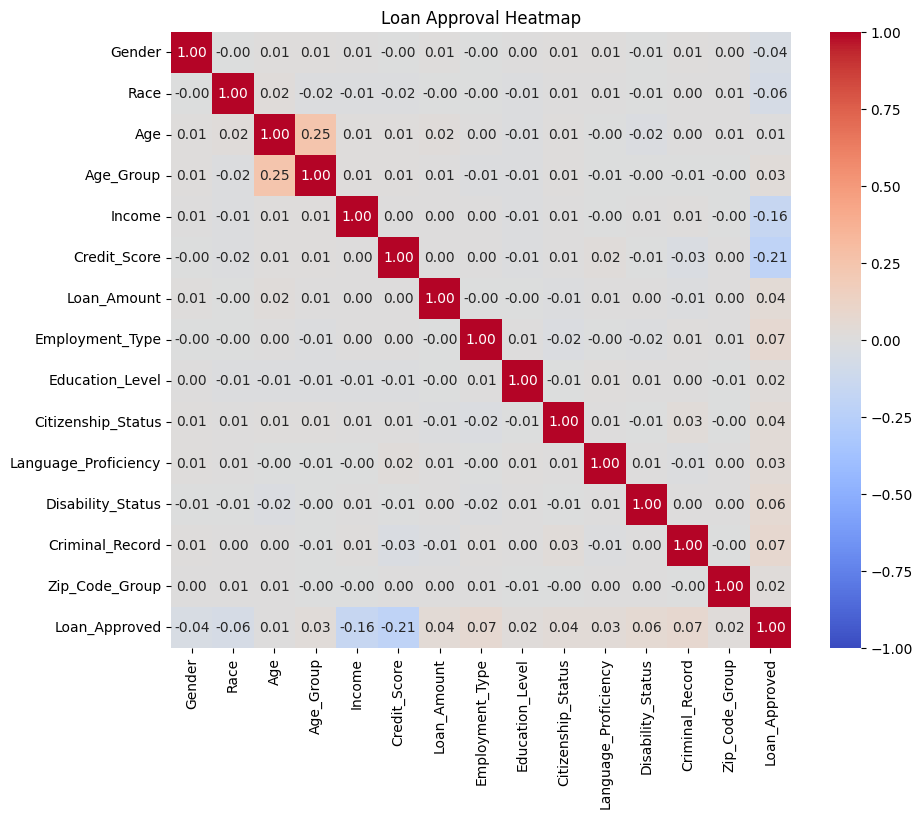

In [81]:
##visualize correlation

plt.figure(figsize=(10,8))
sns.heatmap(temp_df.corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm', annot_kws={'fontsize': 10}, vmin=-1, vmax=1, center=0)
plt.title('Loan Approval Heatmap')
#plt.savefig('heatmap of Loan features.png', dpi=300, bbox_inches='tight')
plt.show()

#### Exploring Bias in the training data

In [82]:
## Plot Loan approval by different groups
def approval_by_group(df, group_column):
    """
    This function plots proportion of loan approval rates by demographics
    """
    group_counts = df.groupby([group_column, 'Loan_Approved']).size().unstack(fill_value=0)
    group_props = group_counts.div(group_counts.sum(axis=1), axis=0)

    
    group_props.columns = ['Denied', 'Approved']
    colors = sns.color_palette('husl', n_colors=2)

    group_props = group_props.sort_values(by='Approved', ascending=False)

    ax = group_props.plot(kind='bar', stacked=True, figsize=(8, 5), color=colors)
    for i, (index,row) in enumerate (group_props.iterrows()):
        denied =row['Denied']
        approved = row['Approved']
        ax.text(i, denied + approved / 2, f"{approved:.0%}", ha='center', va='center', color='white', fontsize=10)


    plt.title(f'Loan Approval Rate by {group_column}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

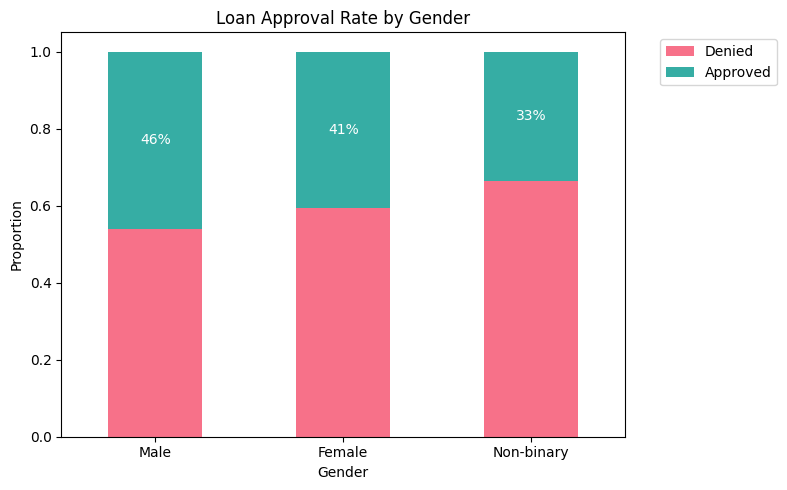

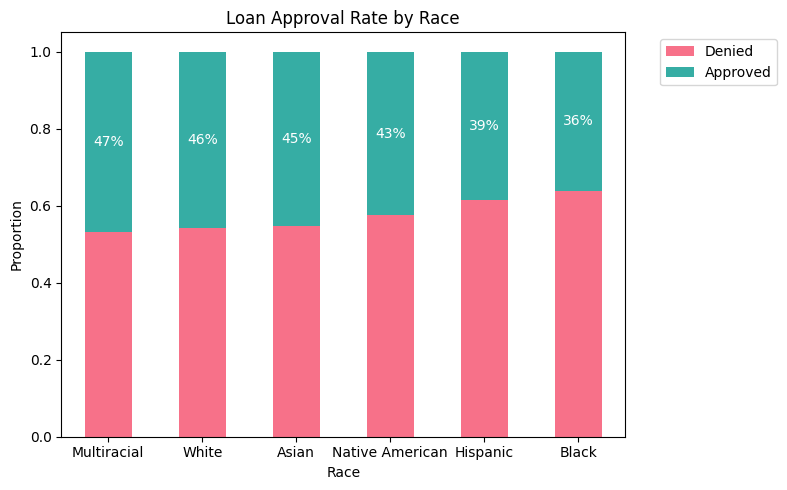

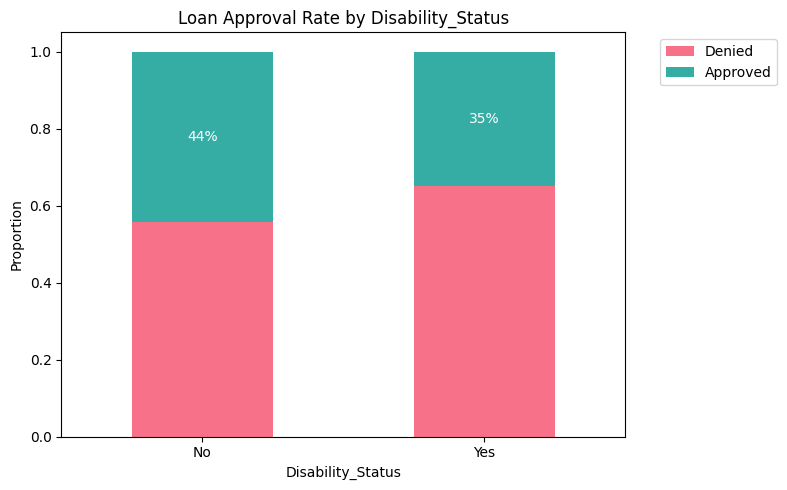

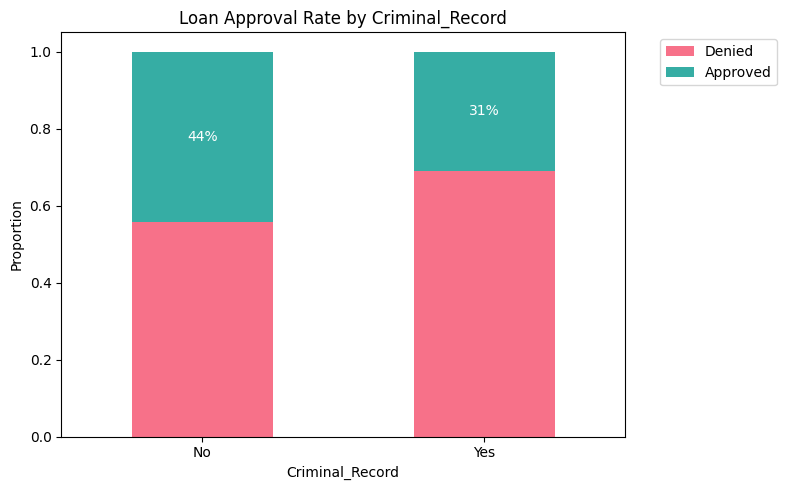

In [83]:
## call approval_by_group
approval_by_group(df, 'Gender')
approval_by_group(df, 'Race')
approval_by_group(df, 'Disability_Status')
approval_by_group(df, 'Criminal_Record')

C:\Users\HP\AppData\Local\Temp\ipykernel_23128\4136526634.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['CreditScore_Group', 'Race'])['Loan_Approved'].mean().unstack()


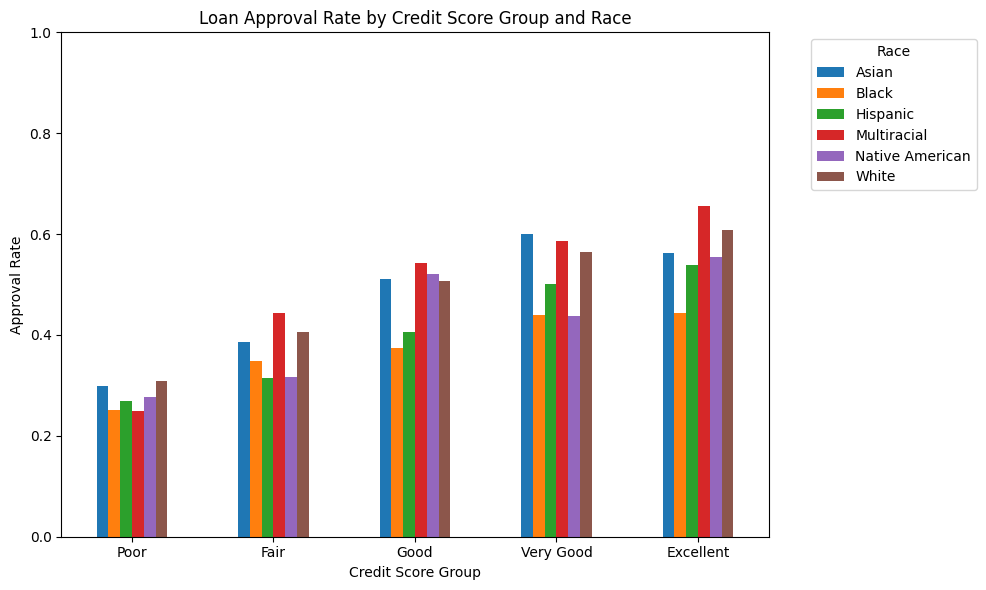

In [84]:
## Create a new feature (credit score group), and visualize
# loan approval rate by credit score group and
# bin credit scores with FICO credit score.
# FICO is a tool used to determine if a person qualifies for a 
## credit card, mortgage , or other loan.

bins = [300, 579, 669, 739, 799, float('inf')]
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
df['CreditScore_Group'] = pd.cut(df['Credit_Score'], bins=bins, labels=labels, include_lowest=True)

# approval rate by group (CreditScore_Group × Race)
grouped = df.groupby(['CreditScore_Group', 'Race'])['Loan_Approved'].mean().unstack()

# Plot bar chart for grouped
grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Loan Approval Rate by Credit Score Group and Race')
plt.ylabel('Approval Rate')
plt.ylim(0, 1)
plt.xlabel('Credit Score Group')
plt.xticks(rotation=0)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Bias detection on an individual basis (training data)

In [85]:
## ========================================================
## Bias Detection: Inspection of Bias on an Individual Basis
## =========================================================
# Some cases are suspicious so they will be flagged e.g high credit score, loan denied
## define limits 

high_credit = df['Credit_Score'].quantile(0.85)
low_credit = df['Credit_Score'].quantile(0.15)
high_income = df['Income'].quantile(0.85)
low_income = df['Income'].quantile(0.15)

## function to flag those cases
def abnormal_cases(df, high_credit, low_credit, high_income, low_income):
    """
    this function flags suspicious cases where:
    1. High credit score but denied
    2. Low credit score but approved
    3. High income but denied
    4. Low income but approved.
    """
    # Create boolean flags for each abnormal condition
    high_credit_denied = (df['Credit_Score'] > high_credit) & (df['Loan_Approved'] == 0)
    low_credit_approved = (df['Credit_Score'] < low_credit) & (df['Loan_Approved'] == 1)
    high_income_denied = (df['Income'] > high_income) & (df['Loan_Approved'] == 0)
    low_income_approved = (df['Income'] < low_income) & (df['Loan_Approved'] == 1)


    df['Suspicious'] = high_credit_denied | low_credit_approved | high_income_denied | low_income_approved
    # Return only suspicious rows for review
    return df[df['Suspicious'] == True].sort_values(by='Credit_Score', ascending=False)


In [86]:
## call the function
abnormal = abnormal_cases(df, high_credit, low_credit, high_income, low_income)
abnormal

,ID,Gender,Race,Age,Age_Group,Income,Credit_Score,Loan_Amount,Employment_Type,Education_Level,Citizenship_Status,Language_Proficiency,Disability_Status,Criminal_Record,Zip_Code_Group,Loan_Approved,CreditScore_Group,Suspicious
8712,8713,Male,White,34,25-60,26869,849,99166,Self-employed,Some College,Citizen,Fluent,No,No,Urban Professional,1,Excellent,True
7229,7230,Male,White,79,Over 60,31073,849,194305,Full-time,Bachelor's,Citizen,Fluent,No,No,Historically Redlined,1,Excellent,True
2755,2756,Male,Native American,69,Over 60,81147,849,164739,Full-time,Graduate,Citizen,Fluent,No,No,High-income Suburban,0,Excellent,True
2527,2528,Male,White,22,Under 25,90205,849,442205,Self-employed,High School,Citizen,Limited,Yes,No,Working Class Urban,0,Excellent,True
2258,2259,Female,Black,35,25-60,94178,849,442705,Full-time,Some College,Citizen,Limited,No,No,High-income Suburban,0,Excellent,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4224,4225,Female,White,25,25-60,137743,500,289781,Gig,Graduate,Citizen,Limited,No,No,Historically Redlined,1,Poor,True
8166,8167,Female,White,21,Under 25,168099,500,386445,Full-time,Graduate,Citizen,Fluent,No,Yes,Rural,0,Poor,True
9348,9349,Female,White,28,25-60,169968,500,420388,Full-time,High School,Citizen,Fluent,No,No,Working Class Urban,0,Poor,True
4737,4738,Female,White,43,25-60,41104,500,449814,Gig,Graduate,Citizen,Fluent,No,No,Working Class Urban,1,Poor,True


In [87]:
## Drop irrelevant features and new features that were created
df = df.drop(columns=['ID', 'Age_Group', 'CreditScore_Group', 'Suspicious'])


In [88]:
#save to csv for review
abnormal.to_csv('Individual_cases_for review.csv')

## Model Development

######
 I will be training two models. One where I exclude the  sensitive features to remove any 
 form of bias then another one where I include sensitive  features for bias auditing.
 sensitive features (Race, Gender, Disability_Status etc).  I will then compare both.
######


In [89]:
## Random Forest will be used to develop the models
# Define the model. 
#for sensitive
rf_s = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
#for insensitive
rf_n = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

##### Define sensitive and non-sensitive features ('s'represents sensitive, 'ns' represents non-sensitive) Group features into sensitive and predictive( what is exactly needed for a loan prediction)
##### 


In [90]:

sensitive_features = ['Gender', 'Race', 'Citizenship_Status','Language_Proficiency', 
                      'Criminal_Record', 'Zip_Code_Group'] 
predictive_features = ['Age','Income', 'Credit_Score', 'Loan_Amount',
                      'Employment_Type', 'Education_Level']


In [91]:
## =======================
# Model with sensitive features:The steps below are for the model that contains sensitive attributes.
#=========================
# define features for training 
num_cols_s = ['Age', 'Income','Credit_Score','Loan_Amount']
cat_cols_s = ['Gender','Race','Employment_Type','Education_Level',
                   'Citizenship_Status','Language_Proficiency','Disability_Status',
                    'Criminal_Record','Zip_Code_Group' ]

#define X and y train
X_s= df[num_cols_s + cat_cols_s]
y_target= df['Loan_Approved']

#split dataframe with stratified sampling
train_idx, val_idx = train_test_split(
    df.index, test_size=0.2, stratify=df['Loan_Approved'], random_state=42
)

X_train_s = df.loc[train_idx, num_cols_s + cat_cols_s]
X_val_s = df.loc[val_idx,num_cols_s + cat_cols_s]
y_train_s = df.loc[train_idx, 'Loan_Approved']
y_val_s = df.loc[val_idx, 'Loan_Approved']


In [92]:
# Categorical columns are to be encoded
categorical_transformer_s = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
#numerical columns are not being scaled because random forest is a tree based model and can handle the values


preprocessor_s = ColumnTransformer([
    ('num', 'passthrough', num_cols_s),
    ('cat', categorical_transformer_s, cat_cols_s)
])

# random forest pipeline for model with sensitive features
rf_pipeline_s = Pipeline([
    ('preprocessor_s', preprocessor_s),
    ('model_s', rf_s)
])

#train and evaluate random forest on model with sensistive features
rf_pipeline_s.fit(X_train_s, y_train_s)
rf_preds_s = rf_pipeline_s.predict(X_val_s)
rf_probs_s = rf_pipeline_s.predict_proba(X_val_s)[:, 1]

print("--- Random Forest Results For Model with Sensitive Features ---")
print(classification_report(y_val_s, rf_preds_s))
print("AUC:", roc_auc_score(y_val_s, rf_probs_s))

--- Random Forest Results For Model with Sensitive Features ---
              precision    recall  f1-score   support

           0       0.69      0.63      0.65      1137
           1       0.56      0.62      0.59       863

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.63      0.62      0.63      2000

AUC: 0.6694988234167082


In [93]:
## =======================
# Model without sensitive features:The steps below are for the model that do not contain sensitive attributes.
# The features used for modeling are: Age,Income, 'redit_Score, Loan_Amount, Employment_Type, Education_Level
#validation set will be used to see the model's performance while X test is 
#used only for prediction
#=========================
# define features for training 

num_cols_n = ['Age', 'Income','Credit_Score','Loan_Amount']
cat_cols_n = ['Employment_Type','Education_Level']

# define x and y
X_n = df[num_cols_n + cat_cols_n]
y_target = df['Loan_Approved']

#data has been split above. Reusing indices
X_train_n = df.loc[train_idx, num_cols_n + cat_cols_n]
X_val_n = df.loc[val_idx,num_cols_n + cat_cols_n]
y_train_n = df.loc[train_idx, 'Loan_Approved']
y_val_n = df.loc[val_idx, 'Loan_Approved']

In [94]:
#categorical columns to be encoded
categorical_transformer_n = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_n = ColumnTransformer([
    ('num', 'passthrough', num_cols_n),
    ('cat', categorical_transformer_n, cat_cols_n)
    ])

#define X test
X_test = test[num_cols_n + cat_cols_n]

rf_pipeline_n = Pipeline([
    ('preprocess_n',preprocessor_n ),
    ('model_n', rf_n)
])

#Train and evaluate Random Forest on model without sensitive features
rf_pipeline_n.fit(X_train_n, y_train_n)
rf_preds_n = rf_pipeline_n.predict(X_val_n)
rf_probs_n = rf_pipeline_n.predict_proba(X_val_n)[:, 1]

print('--- Random Forest Results for Model without Sensitive Features ---')
print(classification_report(y_val_n, rf_preds_n))
print("AUC:", roc_auc_score(y_val_n, rf_probs_n))

--- Random Forest Results for Model without Sensitive Features ---
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      1137
           1       0.55      0.64      0.59       863

    accuracy                           0.61      2000
   macro avg       0.62      0.62      0.61      2000
weighted avg       0.63      0.61      0.62      2000

AUC: 0.6523723771466656


In [95]:
#for the baseline model prediction
#Re-train random forest on full train dataset
X_full_train = df[num_cols_n + cat_cols_n]
y_full_train = df['Loan_Approved']

rf_pipeline_n.fit(X_full_train, y_full_train)

test_preds_n = rf_pipeline_n.predict(X_test)

#add prediction values to submission file
submission = pd.DataFrame({
    'ID': test['ID'],
    'Loan_Approved': test_preds_n
})

submission.to_csv('submission.csv', index=False)


#### SHAP analysis

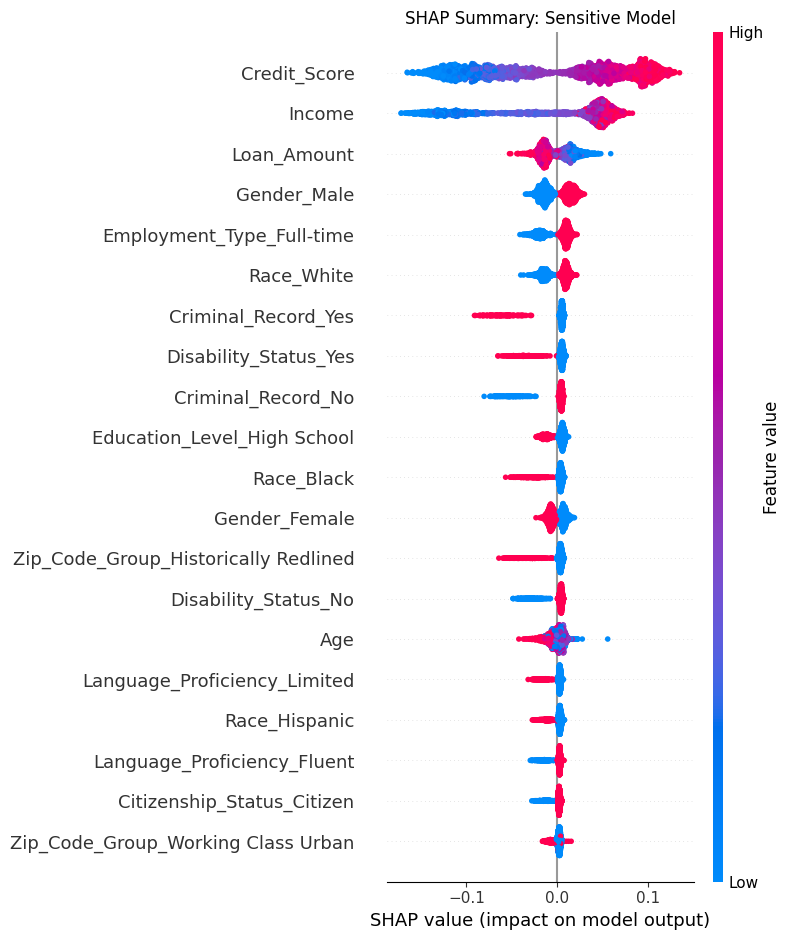

In [96]:
# Two plots will be plotted (one for the sensitive and non sensitive models each)


#for sensitive
# Extract the preprocessor and model from the pipeline
preprocessor_s = rf_pipeline_s.named_steps['preprocessor_s']
model_s = rf_pipeline_s.named_steps['model_s']

# Transform X_val_s for SHAP analysis
X_val_s_transformed = preprocessor_s.transform(X_val_s)

# Get transformed feature names
feature_names_s = preprocessor_s.get_feature_names_out()

# Create a DataFrame for SHAP with feature names (this is to keep full names for consistency with pipeline)
X_val_s_df = pd.DataFrame(X_val_s_transformed.toarray() if hasattr(X_val_s_transformed, 'toarray') else X_val_s_transformed,
                          columns=feature_names_s,
                          index=X_val_s.index)

# Train SHAP explainer and compute values
explainer_s = shap.TreeExplainer(model_s)
shap_values_s = explainer_s.shap_values(X_val_s_df)
shap_class_1_s = shap_values_s[:, :, 1]

# clean feature names for plotting only (remove 'cat' in front of labels for readability)
clean_names_s = [name.replace('cat__', '').replace('num__', '').replace('remainder__', '') for name in feature_names_s]


# Plot SHAP summary
shap.summary_plot(shap_class_1_s, X_val_s_df, feature_names=clean_names_s, show=False)

plt.title('SHAP Summary: Sensitive Model')
plt.tight_layout()
plt.show()

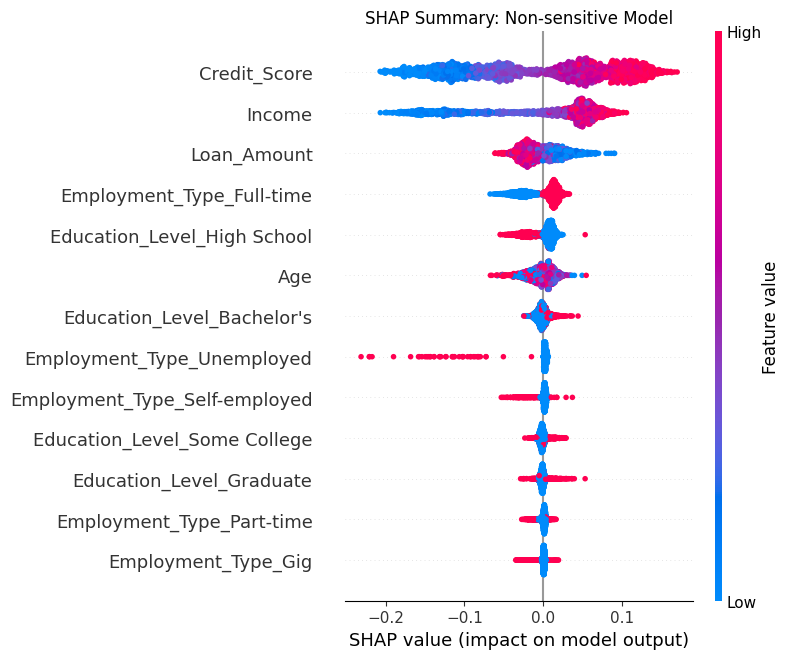

In [97]:
#for non sensistive
# Extract the preprocessor and model from the pipeline
preprocessor_n = rf_pipeline_n.named_steps['preprocess_n']
model_n = rf_pipeline_n.named_steps['model_n']

# Transform X_val_n for SHAP analysis
X_val_n_transformed = preprocessor_n.transform(X_val_n)

# Get transformed feature names
feature_names_n = preprocessor_n.get_feature_names_out()

# Create a DataFrame for SHAP with feature names (keep full names for group prediction later)
X_val_n_df = pd.DataFrame(X_val_n_transformed.toarray() if hasattr(X_val_n_transformed, 'toarray') else X_val_n_transformed,
                          columns=feature_names_n,
                          index=X_val_n.index)

# Train a SHAP explainer and compute values
explainer_n = shap.TreeExplainer(model_n)
shap_values_n = explainer_n.shap_values(X_val_n_df)
shap_class_1_n = shap_values_n[:, :, 1]

# clean feature names for plotting only
clean_names_n = [name.replace('cat__', '').replace('num__', '').replace('remainder__', '') for name in feature_names_n]

# Plot SHAP summary
shap.summary_plot(shap_class_1_n, X_val_n_df, feature_names=clean_names_n, show=False)

plt.title('SHAP Summary: Non-sensitive Model')
plt.tight_layout()
plt.show()

##### Plot Approval Rates

In [98]:
#get the rate of approval for each group
# get sensitive features for the validation set
val_sensitive = df.loc[X_val_n.index, ['Gender', 'Race', 'Disability_Status', 'Criminal_Record']]

# make predictions on the preprocessed validation set
val_preds = rf_pipeline_n.predict(X_val_n)

val_sensitive_preds = val_sensitive.copy()
val_sensitive_preds['Predicted_Loan_Approval'] = val_preds

# compute approval rates by group
# Gender
gender_approval = val_sensitive_preds.groupby('Gender')['Predicted_Loan_Approval'].mean().reset_index()
print('\nApproval Rates by Gender:\n', gender_approval)

# Race
race_approval = val_sensitive_preds.groupby('Race')['Predicted_Loan_Approval'].mean().reset_index()
print("\nApproval Rates by Race:\n", race_approval)

# Disability Status
disability_approval = val_sensitive_preds.groupby('Disability_Status')['Predicted_Loan_Approval'].mean().reset_index()
print("\nApproval Rates by Disability Status:\n", disability_approval)


# Criminal Record
Criminal_record_approval = val_sensitive_preds.groupby('Criminal_Record')['Predicted_Loan_Approval'].mean().reset_index()
print("\nApproval Rates by Criminal Record:\n", Criminal_record_approval)



Approval Rates by Gender:
        Gender  Predicted_Loan_Approval
0      Female                 0.472195
1        Male                 0.507463
2  Non-binary                 0.486486

Approval Rates by Race:
               Race  Predicted_Loan_Approval
0            Asian                 0.491228
1            Black                 0.484321
2         Hispanic                 0.472141
3      Multiracial                 0.431818
4  Native American                 0.470588
5            White                 0.497076

Approval Rates by Disability Status:
   Disability_Status  Predicted_Loan_Approval
0                No                 0.494350
1               Yes                 0.447826

Approval Rates by Criminal Record:
   Criminal_Record  Predicted_Loan_Approval
0              No                 0.492391
1             Yes                 0.450000


C:\Users\HP\AppData\Local\Temp\ipykernel_23128\898918053.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=group, y='Predicted_Loan_Approval', data=data, palette='pastel')


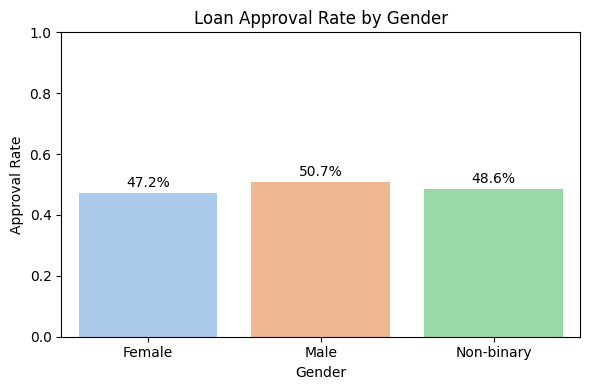

C:\Users\HP\AppData\Local\Temp\ipykernel_23128\898918053.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=group, y='Predicted_Loan_Approval', data=data, palette='pastel')


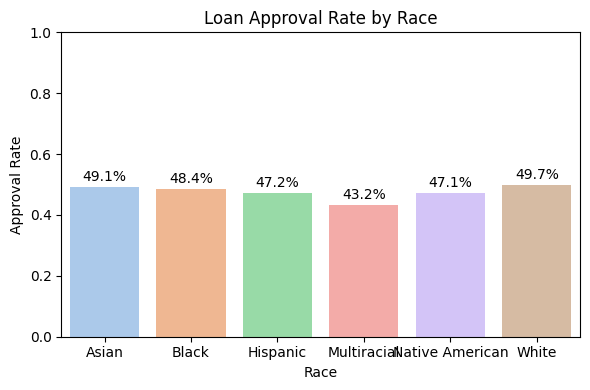

C:\Users\HP\AppData\Local\Temp\ipykernel_23128\898918053.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=group, y='Predicted_Loan_Approval', data=data, palette='pastel')


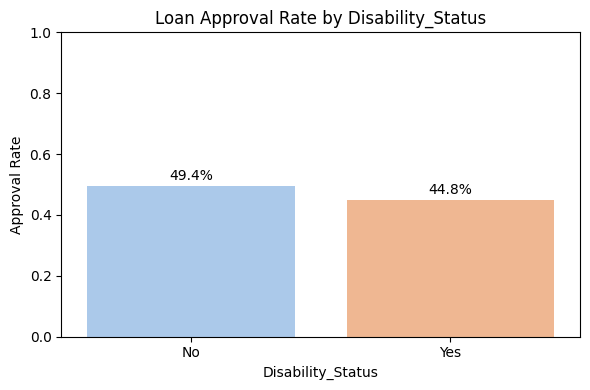

C:\Users\HP\AppData\Local\Temp\ipykernel_23128\898918053.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=group, y='Predicted_Loan_Approval', data=data, palette='pastel')


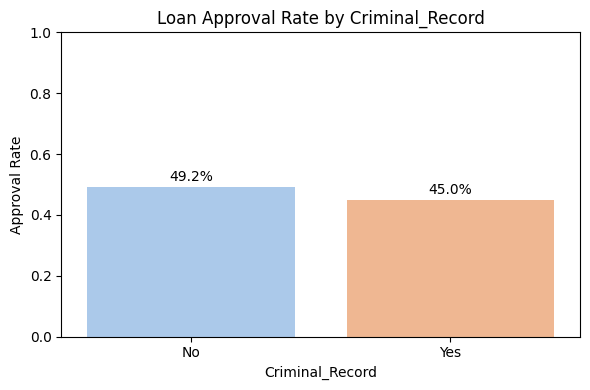

In [99]:
#plot bar charts for approval rates
# Dictionary to map groups names to the approval rate DataFrames above
group_data = {
    'Gender': gender_approval,
    'Race': race_approval,
    'Disability_Status': disability_approval,
    'Criminal_Record': Criminal_record_approval
}

# Loop through each group and plot
for group, data in group_data.items():
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=group, y='Predicted_Loan_Approval', data=data, palette='pastel')
    plt.title(f'Loan Approval Rate by {group}')
    plt.ylabel('Approval Rate')
    plt.ylim(0, 1)

   
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 0.02, f'{height:.1%}', ha='center')

    plt.tight_layout()
    plt.show()

##### False Positive (FPR) and False Negative Rate (FNR) Calculation

In [100]:
# Function to calculate FPR and FNR for each group
def compute_error_rates(df, group_col, y_true, y_pred):
    """this function calculates the false
    positive rate and false negative rate for
    each group"""
    results = []
    for group in df[group_col].unique():
        idx = df[group_col] == group
        y_true_group = y_true[idx]
        y_pred_group = y_pred[idx]

        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1]).ravel()
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

        results.append({'Group': group, 'FPR': round(fpr, 3), 'FNR': round(fnr, 3)})
    
    return pd.DataFrame(results)


In [101]:
# Apply to each sensitive groups
val_sensitive_preds['True_Label'] = y_val_n  # y_val_n is your true labels
groups = ['Gender', 'Race', 'Disability_Status', 'Criminal_Record']

for group_col in groups:
    print(f"\nError rates for {group_col}:")
    error_df = compute_error_rates(val_sensitive_preds, group_col,
                                   val_sensitive_preds['True_Label'],
                                   val_sensitive_preds['Predicted_Loan_Approval'])
    print(error_df)



Error rates for Gender:
        Group    FPR    FNR
0        Male  0.264  0.193
1      Female  0.256  0.225
2  Non-binary  0.190  0.125

Error rates for Race:
             Group    FPR    FNR
0            White  0.238  0.202
1      Multiracial  0.208  0.300
2         Hispanic  0.285  0.213
3            Asian  0.220  0.218
4            Black  0.319  0.202
5  Native American  0.222  0.250

Error rates for Disability_Status:
  Group    FPR    FNR
0   Yes  0.253  0.188
1    No  0.259  0.209

Error rates for Criminal_Record:
  Group    FPR    FNR
0    No  0.258  0.207
1   Yes  0.262  0.211


##### Plot bar charts for FPR and NPR

C:\Users\HP\AppData\Local\Temp\ipykernel_23128\1394079569.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y=error_type, data=error_df, palette='pastel')


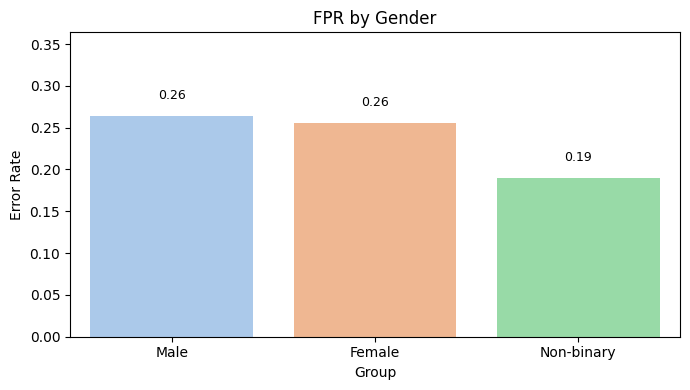

C:\Users\HP\AppData\Local\Temp\ipykernel_23128\1394079569.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y=error_type, data=error_df, palette='pastel')


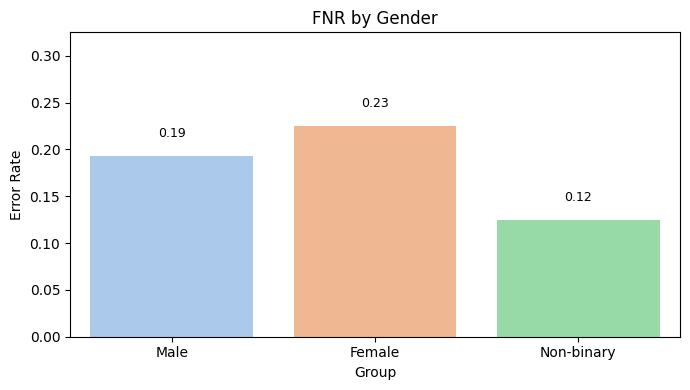

C:\Users\HP\AppData\Local\Temp\ipykernel_23128\1394079569.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y=error_type, data=error_df, palette='pastel')


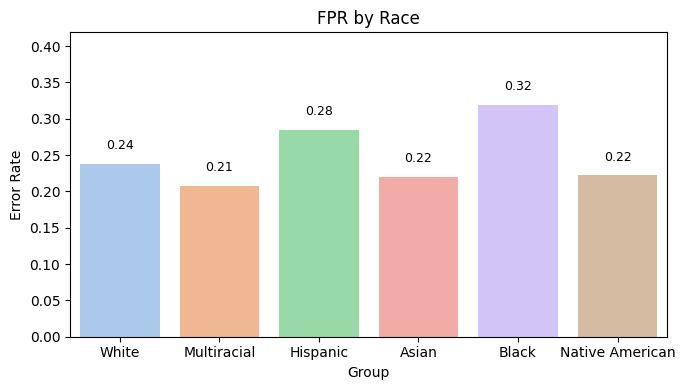

C:\Users\HP\AppData\Local\Temp\ipykernel_23128\1394079569.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y=error_type, data=error_df, palette='pastel')


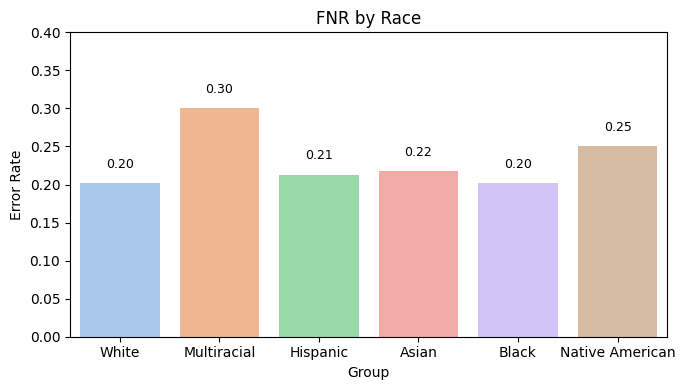

In [102]:
# List of groups and their titles
groups = ['Gender', 'Race']
error_types = ['FPR', 'FNR']

for group_col in groups:
    # Get error rates for this group
    error_df = compute_error_rates(val_sensitive_preds, group_col,
                                   val_sensitive_preds['True_Label'],
                                   val_sensitive_preds['Predicted_Loan_Approval'])
    
    # For each error type (FPR and FNR), plot a bar chart
    for error_type in error_types:
        plt.figure(figsize=(7, 4))
        ax = sns.barplot(x='Group', y=error_type, data=error_df, palette='pastel')

        # Add value labels on bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', fontsize=9)

        plt.title(f'{error_type} by {group_col}')
        plt.ylabel('Error Rate')
        plt.ylim(0, max(error_df[error_type]) + 0.1)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
